In [2]:

import numpy as np
import cv2 as cv
import os
sift_all = []
for i in range(len(os.listdir('imgs'))):
    img = cv.imread('imgs/'+os.listdir('imgs')[i])
    sift = cv.SIFT_create()
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    kp = []
    des = []
    k = 60
    for l in range(img.shape[0]//k):
        for j in range(img.shape[1]//k):
            kp_block = sift.detect(gray[l*k:(l+1)*k,j*k:(j+1)*k], None)
            # extract only the strongest keypoints in each block
            kp_block = sorted(kp_block, key=lambda x: -x.response)[:1]
            # if there is no keypoint in the block, take the centre point as the keypoint
            if len(kp_block) == 0:
                kp_block = [cv.KeyPoint(l*k+k/2,j*k+k/2,k)]
            kp_block,des_block = sift.compute(gray[l*k:(l+1)*k,j*k:(j+1)*k],kp_block)

            kp.append(kp_block)
            des.append(des_block)
    
    sift_all.extend(des)
sift_all = np.array(sift_all)
sift_all = sift_all.reshape(sift_all.shape[0],sift_all.shape[2])

In [13]:
import numpy as np
import cv2
import os
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
# A k-means clustering algorithm who takes 2 parameter which is number 
# of cluster(k) and the other is descriptors list(unordered 1d array)
# Returns an array that holds central points.
def kmeans(k, sift_features):
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(sift_features)
    visual_words = kmeans.cluster_centers_ 
    return visual_words
    
# Takes the central points which is visual words    
visual_words = kmeans(50, sift_all)

In [14]:
visual_words.shape

(50, 128)

In [5]:

with open('image_words_sift.txt','w') as f:
    for i in range(visual_words.shape[0]):
        f.write(str(visual_words[i,:])+'\n')

In [15]:
def read_sift_vectors(filename):
    sift_vectors = []
    x = 0
    # parse the file at paranthesis
    with open(filename, 'r') as f:
        # read first line of f
        line = f.readline()
        while line:
            temp_list = []
            line = line.strip()
            if line.startswith('['):
                while(not (line.endswith(']\n') or line.endswith(']'))):
                    temp = line.replace('[', '')
                    temp = temp.replace(']', '')
                    temp = temp.replace('\n', '')
                    if(temp[0] == ' '):
                        temp = temp[1:]
                    temp = temp.split(' ')
                    # remove empty strings
                    temp = list(filter(None, temp))
                    temp_list.extend(float(temp[i]) for i in range(len(temp)))
                    line = f.readline()
                temp = line.replace('[', '')
                temp = temp.replace(']', '') 
                temp = temp.replace('\n', '')
                if(temp[0] == ' '):
                    temp = temp[1:]
                temp = temp.split(' ')
                # remove empty strings
                temp = list(filter(None, temp))
                temp_list.extend(float(temp[i]) for i in range(len(temp)))


            # convert to numpy array
            # parse the list to get the float values
            temp_list = [float(i) for i in temp_list]
            temp_list = np.array(temp_list)
            sift_vectors.append(temp_list)
            line = f.readline()



    return np.array(sift_vectors)

In [16]:
sift_file = './image_words_sift.txt'

# read the sift vectors
sift_vectors = read_sift_vectors(sift_file)


In [17]:
def getFeatureVectors_sift(img, vocabulary):
    features = np.zeros(vocabulary.shape[0])
    sift = cv.SIFT_create()
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    kp = []
    des = []
    k = 60
    for l in range(img.shape[0]//k):
        for j in range(img.shape[1]//k):
            kp_block = sift.detect(gray[l*k:(l+1)*k,j*k:(j+1)*k], None)
            # extract only the strongest keypoints in each block
            kp_block = sorted(kp_block, key=lambda x: -x.response)[:1]
            # if there is no keypoint in the block, take the centre point as the keypoint
            if len(kp_block) == 0:
                kp_block = [cv.KeyPoint(l*k+k/2,j*k+k/2,k)]
            kp_block,des_block = sift.compute(gray[l*k:(l+1)*k,j*k:(j+1)*k],kp_block)

            # find minimum distance between the descriptors of the block and the vocabulary
            features[np.argmin([np.linalg.norm(des_block - v) for v in vocabulary])] += 1

    return features


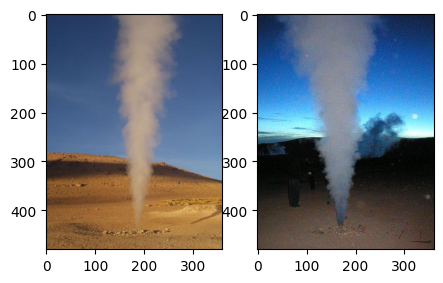

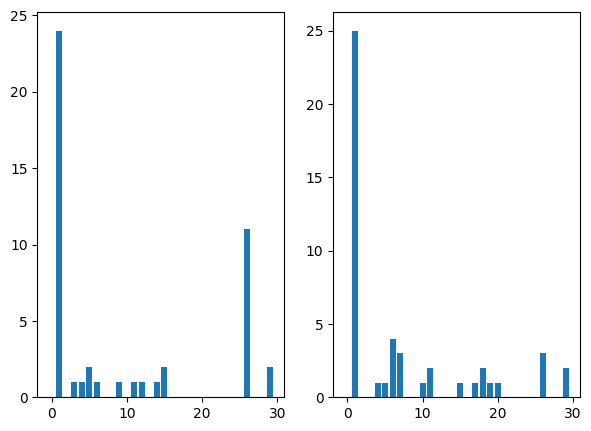

<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt

img1 = cv.imread('./imgs/1877.jpg')
img2 = cv.imread('./imgs/1879.jpg')

feature_vectors1 = getFeatureVectors_sift(img1, sift_vectors)
feature_vectors2 = getFeatureVectors_sift(img2, sift_vectors)

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)
plt.show()
plt.figure(figsize=(7,5))
plt.subplot(1,2,1)
plt.bar(range(len(feature_vectors1)), feature_vectors1)
plt.subplot(1,2,2)
plt.bar(range(len(feature_vectors2)), feature_vectors2)
plt.show()
# save the images 
plt.savefig('sift_feature_vectors.png')




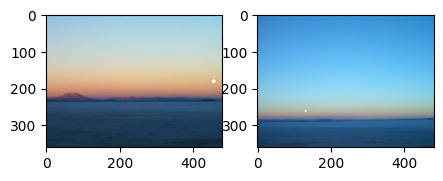

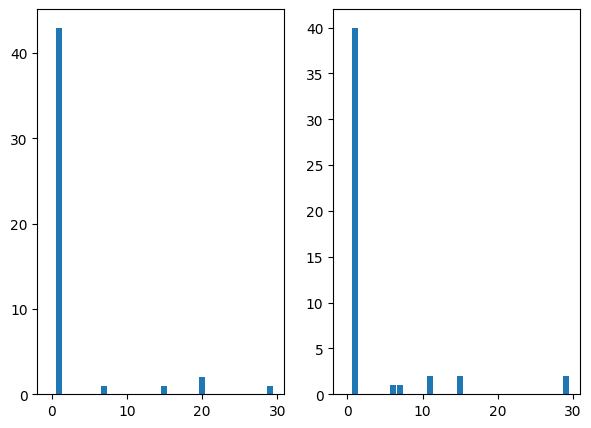

In [27]:
img1 = cv.imread('./imgs/1785.jpg')
img2 = cv.imread('./imgs/1786.jpg')

feature_vectors1 = getFeatureVectors_sift(img1, sift_vectors)
feature_vectors2 = getFeatureVectors_sift(img2, sift_vectors)

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)
plt.show()

plt.figure(figsize=(7,5))
plt.subplot(1,2,1)
plt.bar(range(len(feature_vectors1)), feature_vectors1)
plt.subplot(1,2,2)
plt.bar(range(len(feature_vectors2)), feature_vectors2)
plt.show()


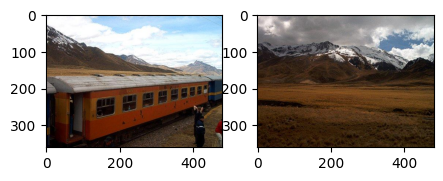

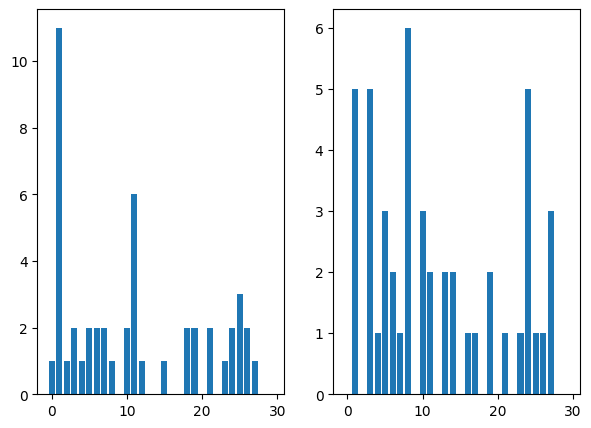

<Figure size 640x480 with 0 Axes>

In [23]:
img1 = cv.imread('./imgs/2095.jpg')
img2 = cv.imread('./imgs/2094.jpg')

feature_vectors1 = getFeatureVectors_sift(img1, sift_vectors)
feature_vectors2 = getFeatureVectors_sift(img2, sift_vectors)

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)
plt.show()

plt.figure(figsize=(7,5))
plt.subplot(1,2,1)
plt.bar(range(len(feature_vectors1)), feature_vectors1)
plt.subplot(1,2,2)
plt.bar(range(len(feature_vectors2)), feature_vectors2)
plt.show()
# save the images
plt.savefig('sift_feature_vectors3.png')

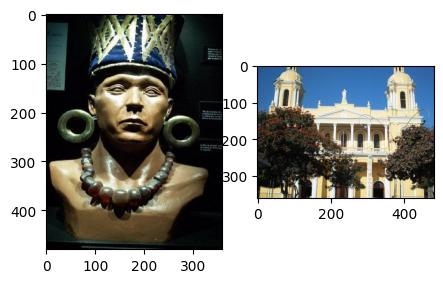

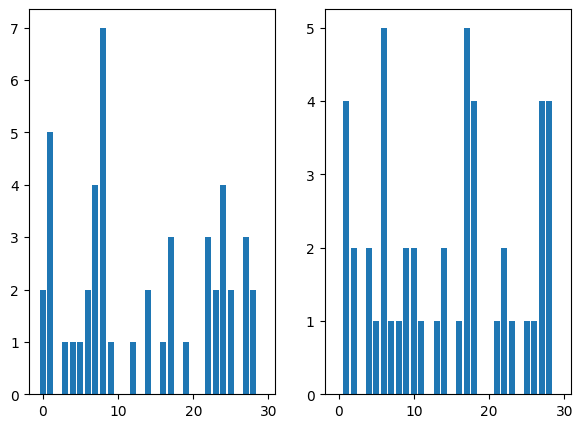

<Figure size 640x480 with 0 Axes>

In [25]:
img1 = cv.imread('./imgs/2369.jpg')
img2 = cv.imread('./imgs/2377.jpg')

feature_vectors1 = getFeatureVectors_sift(img1, sift_vectors)
feature_vectors2 = getFeatureVectors_sift(img2, sift_vectors)

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)
plt.show()

plt.figure(figsize=(7,5))
plt.subplot(1,2,1)
plt.bar(range(len(feature_vectors1)), feature_vectors1)
plt.subplot(1,2,2)
plt.bar(range(len(feature_vectors2)), feature_vectors2)
plt.show()
# save the histogram images
plt.savefig('sift_feature_vectors4.png')



In [46]:

import numpy as np
import cv2 as cv
import os
k = 60
mstd_features = np.zeros((len(os.listdir('imgs'))*(360//k)*(480//k),6))

index = 0
for i in range(len(os.listdir('imgs'))):
    img = cv.imread('imgs/'+os.listdir('imgs')[i])
    
    img = img/255
    colors_sum = img[...,0] + img[...,1] + img[...,2]
    r_ratio = img[...,2]/(colors_sum+0.0001)
    g_ratio = img[...,1]/(colors_sum+0.0001)
    norm = colors_sum/3

    for j in range(img.shape[0]//k):
        for l in range(img.shape[1]//k):
            r_avg = []
            g_avg = []
            norm_avg = []
            
            r_std = []
            g_std = []
            norm_std = []
            r_avg.append(np.mean(r_ratio[j*k:(j+1)*k,l*k:(l+1)*k]))
            g_avg.append(np.mean(g_ratio[j*k:(j+1)*k,l*k:(l+1)*k]))
            norm_avg.append(np.mean(norm[j*k:(j+1)*k,l*k:(l+1)*k]))

            r_std.append(np.std(r_ratio[j*k:(j+1)*k,l*k:(l+1)*k]))
            g_std.append(np.std(g_ratio[j*k:(j+1)*k,l*k:(l+1)*k]))
            norm_std.append(np.std(norm[j*k:(j+1)*k,l*k:(l+1)*k]))

            # reshape the arrays to 1D
            r_avg = np.array(r_avg).reshape(-1)
            g_avg = np.array(g_avg).reshape(-1)
            norm_avg = np.array(norm_avg).reshape(-1)
            r_std = np.array(r_std).reshape(-1)
            g_std = np.array(g_std).reshape(-1)
            norm_std = np.array(norm_std).reshape(-1)
            # hstack the arrays 
            mstd = (np.hstack((r_avg, g_avg, norm_avg, r_std, g_std, norm_std))) 
            mstd_features[index] = mstd
            index += 1

In [47]:
def distance(x,y):
    return np.sqrt(np.sum((x-y)**2))

def mean(x):
    return np.sum(x,axis=0)/len(x)




In [48]:
def k_means_clustering(X,k):
    # centers = X[np.random.choice(k,X.shape[1],replace=False),:]
    # initializing centers to 0
    centers = np.zeros((k,X.shape[1]))

    # randomly initializing centers
    for i in range(k):
        centers[i] = X[np.random.randint(0,X.shape[0]),:]

    labels = np.zeros(X.shape[0])
    
    dist = np.zeros((X.shape[0],k))
 
    n_iter = 0
    
    n_changes = 0

    prev_labels = labels.copy()
    while True:
        for i in range(k):
            # dist[:,i] = np.apply_along_axis(distance,1,X,centers[i,:])
            dist[:, i] = np.sqrt(np.sum((X - centers[i, :]) ** 2, axis=1))
        labels = np.argmin(dist,axis=1)
       
        for i in range(k):
            if(len(X[labels==i])>0):
                centers[i,:] = mean(X[labels==i,:])
  
        n_changes = len(labels[np.abs(labels-prev_labels)>0.0001*np.ones(labels.shape)])
        print(n_changes)
    
        prev_labels = labels.copy()
       
        n_iter += 1
  
        if n_changes<=0.01*X.shape[0]:
            break
    return labels,centers,n_iter


In [ ]:
labels,centers,n_iter = k_means_clustering(mstd_features,30)


In [50]:
with open('image_words_mstd.txt','w') as f:
    for i in range(centers.shape[0]):
        f.write(str(centers[i,:])+'\n')

In [51]:
mstd_vocabulary = read_sift_vectors('./image_words_mstd.txt')

In [52]:
def getMSTDfeatures(img, vocabulary):
    k = 60
    img = img/255
    colors_sum = img[...,0] + img[...,1] + img[...,2]
    r_ratio = img[...,2]/(colors_sum+0.0001)
    g_ratio = img[...,1]/(colors_sum+0.0001)
    norm = colors_sum/3
    features = [0]*vocabulary.shape[0]

    for j in range(img.shape[0]//k):
        for l in range(img.shape[1]//k):
            r_avg = []
            g_avg = []
            norm_avg = []
            
            r_std = []
            g_std = []
            norm_std = []
            r_avg.append(np.mean(r_ratio[j*k:(j+1)*k,l*k:(l+1)*k]))
            g_avg.append(np.mean(g_ratio[j*k:(j+1)*k,l*k:(l+1)*k]))
            norm_avg.append(np.mean(norm[j*k:(j+1)*k,l*k:(l+1)*k]))

            r_std.append(np.std(r_ratio[j*k:(j+1)*k,l*k:(l+1)*k]))
            g_std.append(np.std(g_ratio[j*k:(j+1)*k,l*k:(l+1)*k]))
            norm_std.append(np.std(norm[j*k:(j+1)*k,l*k:(l+1)*k]))

            # reshape the arrays to 1D
            r_avg = np.array(r_avg).reshape(-1)
            g_avg = np.array(g_avg).reshape(-1)
            norm_avg = np.array(norm_avg).reshape(-1)
            r_std = np.array(r_std).reshape(-1)
            g_std = np.array(g_std).reshape(-1)
            norm_std = np.array(norm_std).reshape(-1)
            # hstack the arrays 
            mstd = (np.hstack((r_avg, g_avg, norm_avg, r_std, g_std, norm_std))) 

            features[np.argmin(np.linalg.norm(vocabulary - mstd, axis=1))] += 1

    return features
